# Transition State Search (NEBs)

FAIR chemistry models can be used to enumerate and study reaction pathways via transition state search tools built into ASE or in packages like Sella via the ASE interface.

The first section of this tutorial walks through how to use the CatTsunami tools to automatically enumerate a number of hypothetical initial/final configurations for various types of reactions on a heterogeneous catalyst surface. If you already have a NEB you're looking to optimize, you can jump straight to the last section (Run NEBs)!

Since the NEB calculations here can be a bit time consuming, we'll use a small number of steps during the documentation testing, and otherwise use a reasonable guess.

In [1]:
import os

# Use a small number of steps here to keep the docs fast during CI, but otherwise do quite reasonable settings.
fast_docs = os.environ.get("FAST_DOCS", "false").lower() == "true"
if fast_docs:
    optimization_steps = 20
else:
    optimization_steps = 300

````{admonition} Need to install fairchem-core or get UMA access or getting permissions/401 errors?
:class: dropdown


1. Install the necessary packages using pip, uv etc
```{code-cell} ipython3
:tags: [skip-execution]

! pip install fairchem-core fairchem-data-oc fairchem-applications-cattsunami
```

2. Get access to any necessary huggingface gated models
    * Get and login to your Huggingface account
    * Request access to https://huggingface.co/facebook/UMA
    * Create a Huggingface token at https://huggingface.co/settings/tokens/ with the permission "Permissions: Read access to contents of all public gated repos you can access"
    * Add the token as an environment variable using `huggingface-cli login` or by setting the HF_TOKEN environment variable.

```{code-cell} ipython3
:tags: [skip-execution]

# Login using the huggingface-cli utility
! huggingface-cli login

# alternatively,
import os
os.environ['HF_TOKEN'] = 'MY_TOKEN'
```

````

## Do enumerations in an AdsorbML style

In [2]:
from __future__ import annotations

import matplotlib.pyplot as plt
from ase.io import read
from ase.mep import DyNEB
from ase.optimize import BFGS
from fairchem.applications.cattsunami.core import Reaction
from fairchem.applications.cattsunami.core.autoframe import AutoFrameDissociation
from fairchem.applications.cattsunami.databases import DISSOCIATION_REACTION_DB_PATH
from fairchem.core import FAIRChemCalculator, pretrained_mlip
from fairchem.data.oc.core import Adsorbate, AdsorbateSlabConfig, Bulk, Slab
from fairchem.data.oc.databases.pkls import ADSORBATE_PKL_PATH, BULK_PKL_PATH
from x3dase.x3d import X3D

# Instantiate the reaction class for the reaction of interest
reaction = Reaction(
    reaction_str_from_db="*CH -> *C + *H",
    reaction_db_path=DISSOCIATION_REACTION_DB_PATH,
    adsorbate_db_path=ADSORBATE_PKL_PATH,
)

In [3]:
# Instantiate our adsorbate class for the reactant and product
reactant = Adsorbate(
    adsorbate_id_from_db=reaction.reactant1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product1 = Adsorbate(
    adsorbate_id_from_db=reaction.product1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product2 = Adsorbate(
    adsorbate_id_from_db=reaction.product2_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)

In [4]:
# Grab the bulk and cut the slab we are interested in
bulk = Bulk(bulk_src_id_from_db="mp-33", bulk_db_path=BULK_PKL_PATH)
slab = Slab.from_bulk_get_specific_millers(bulk=bulk, specific_millers=(0, 0, 1))

In [5]:
# Perform site enumeration
# For AdsorbML num_sites = 100, but we use 5 here for brevity. This should be increased for practical use.
reactant_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=reactant,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product1_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product1,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product2_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product2,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list

In [6]:
# Instantiate the calculator
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1")
calc = FAIRChemCalculator(predictor, task_name="oc20")

In [7]:
# Relax the reactant systems
reactant_energies = []
for config in reactant_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    reactant_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 05:22:53     -301.635040        4.087651


BFGS:    1 05:22:53     -302.021198        3.274333


BFGS:    2 05:22:54     -303.047805        3.309308


BFGS:    3 05:22:54     -303.206566        4.520027


BFGS:    4 05:22:54     -303.512302        2.447057


BFGS:    5 05:22:54     -303.809769        2.531893


BFGS:    6 05:22:54     -303.907363        1.788966


BFGS:    7 05:22:54     -304.014433        1.927070


BFGS:    8 05:22:54     -304.086867        0.907380


BFGS:    9 05:22:54     -304.157983        0.852462


BFGS:   10 05:22:54     -304.284973        1.069737


BFGS:   11 05:22:54     -304.366516        1.288283


BFGS:   12 05:22:54     -304.485678        1.044118


BFGS:   13 05:22:55     -304.559406        0.804207


BFGS:   14 05:22:55     -304.582454        0.670535


BFGS:   15 05:22:55     -304.600295        0.611461


BFGS:   16 05:22:55     -304.622914        0.406910


BFGS:   17 05:22:55     -304.631514        0.330986


BFGS:   18 05:22:55     -304.637070        0.306028


BFGS:   19 05:22:55     -304.642211        0.261748


BFGS:   20 05:22:55     -304.650994        0.385578


BFGS:   21 05:22:55     -304.662769        0.371529


BFGS:   22 05:22:55     -304.672492        0.236181


BFGS:   23 05:22:55     -304.677605        0.188264


BFGS:   24 05:22:55     -304.681243        0.217069


BFGS:   25 05:22:56     -304.684906        0.191263


BFGS:   26 05:22:56     -304.688037        0.137704


BFGS:   27 05:22:56     -304.689830        0.097668


BFGS:   28 05:22:56     -304.690666        0.063581


BFGS:   29 05:22:56     -304.691096        0.068203


BFGS:   30 05:22:56     -304.691419        0.062836


BFGS:   31 05:22:56     -304.691753        0.048656


      Step     Time          Energy          fmax
BFGS:    0 05:22:56     -302.496020        3.991482


BFGS:    1 05:22:56     -302.854682        2.847279


BFGS:    2 05:22:57     -303.694731        3.216690


BFGS:    3 05:22:57     -303.864716        2.850189


BFGS:    4 05:22:57     -304.162454        1.396218


BFGS:    5 05:22:57     -304.235990        1.459039


BFGS:    6 05:22:57     -304.501778        1.679082


BFGS:    7 05:22:57     -304.575263        0.975456


BFGS:    8 05:22:57     -304.607555        0.801686


BFGS:    9 05:22:57     -304.658517        0.619432


BFGS:   10 05:22:57     -304.669885        0.454149


BFGS:   11 05:22:57     -304.680541        0.147892


BFGS:   12 05:22:57     -304.682032        0.102222


BFGS:   13 05:22:57     -304.682887        0.098620


BFGS:   14 05:22:58     -304.684111        0.090297


BFGS:   15 05:22:58     -304.685476        0.084301


BFGS:   16 05:22:58     -304.686518        0.082973


BFGS:   17 05:22:58     -304.687287        0.092936


BFGS:   18 05:22:58     -304.688219        0.091652


BFGS:   19 05:22:58     -304.689366        0.069252


BFGS:   20 05:22:58     -304.690258        0.045094


      Step     Time          Energy          fmax
BFGS:    0 05:22:58     -300.966413        4.051584


BFGS:    1 05:22:58     -301.362065        3.358859


BFGS:    2 05:22:58     -302.498297        3.478137


BFGS:    3 05:22:58     -302.372715        7.644518


BFGS:    4 05:22:59     -302.821959        2.805690


BFGS:    5 05:22:59     -302.976479        1.688318


BFGS:    6 05:22:59     -303.068482        1.831718


BFGS:    7 05:22:59     -303.099503        0.807123


BFGS:    8 05:22:59     -303.139129        0.952783


BFGS:    9 05:22:59     -303.176112        1.132298


BFGS:   10 05:22:59     -303.202233        0.835536


BFGS:   11 05:22:59     -303.215939        0.382050


BFGS:   12 05:22:59     -303.220864        0.267901


BFGS:   13 05:22:59     -303.225209        0.432451


BFGS:   14 05:22:59     -303.232149        0.477122


BFGS:   15 05:22:59     -303.237697        0.397420


BFGS:   16 05:23:00     -303.242360        0.345545


BFGS:   17 05:23:00     -303.247977        0.406427


BFGS:   18 05:23:00     -303.266308        0.821398


BFGS:   19 05:23:00     -303.352743        1.952587


BFGS:   20 05:23:00     -303.534507        2.355590


BFGS:   21 05:23:00     -303.506221        3.383739


BFGS:   22 05:23:00     -303.660468        2.143462


BFGS:   23 05:23:00     -303.721126        1.959246


BFGS:   24 05:23:00     -304.026809        1.115661


BFGS:   25 05:23:00     -304.083217        1.259814


BFGS:   26 05:23:00     -304.152468        1.259334


BFGS:   27 05:23:01     -304.208261        0.945041


BFGS:   28 05:23:01     -304.247082        0.703237


BFGS:   29 05:23:01     -304.269593        0.385663


BFGS:   30 05:23:01     -304.278416        0.346546


BFGS:   31 05:23:01     -304.290264        0.342967


BFGS:   32 05:23:01     -304.303713        0.378454


BFGS:   33 05:23:01     -304.315390        0.383518


BFGS:   34 05:23:01     -304.323703        0.324811


BFGS:   35 05:23:01     -304.329079        0.259884


BFGS:   36 05:23:01     -304.334238        0.204241


BFGS:   37 05:23:01     -304.338826        0.212027


BFGS:   38 05:23:01     -304.342448        0.221971


BFGS:   39 05:23:02     -304.346008        0.205021


BFGS:   40 05:23:02     -304.349246        0.157900


BFGS:   41 05:23:02     -304.352128        0.104634


BFGS:   42 05:23:02     -304.353826        0.095157


BFGS:   43 05:23:02     -304.354527        0.097688


BFGS:   44 05:23:02     -304.354810        0.086612


BFGS:   45 05:23:02     -304.355095        0.082715


BFGS:   46 05:23:02     -304.355514        0.089734


BFGS:   47 05:23:02     -304.355946        0.083030


BFGS:   48 05:23:02     -304.356207        0.065332


BFGS:   49 05:23:02     -304.356301        0.060508


BFGS:   50 05:23:03     -304.356360        0.066904


BFGS:   51 05:23:03     -304.356434        0.069815


BFGS:   52 05:23:03     -304.356513        0.065371


BFGS:   53 05:23:03     -304.356571        0.054567


BFGS:   54 05:23:03     -304.356603        0.044782


      Step     Time          Energy          fmax
BFGS:    0 05:23:03     -302.701422        3.680643


BFGS:    1 05:23:03     -303.042716        2.603767


BFGS:    2 05:23:03     -303.760042        3.043500


BFGS:    3 05:23:03     -303.890406        2.335871


BFGS:    4 05:23:03     -304.050322        2.418870


BFGS:    5 05:23:03     -304.101787        1.048656


BFGS:    6 05:23:03     -304.164776        0.674564


BFGS:    7 05:23:04     -304.222969        0.706097


BFGS:    8 05:23:04     -304.253078        0.514180


BFGS:    9 05:23:04     -304.269776        0.401124


BFGS:   10 05:23:04     -304.285375        0.371057


BFGS:   11 05:23:04     -304.299782        0.381523


BFGS:   12 05:23:04     -304.307746        0.265809


BFGS:   13 05:23:04     -304.311313        0.221781


BFGS:   14 05:23:04     -304.318357        0.301420


BFGS:   15 05:23:04     -304.326197        0.389441


BFGS:   16 05:23:04     -304.333384        0.312099


BFGS:   17 05:23:04     -304.337519        0.206057


BFGS:   18 05:23:05     -304.339663        0.180996


BFGS:   19 05:23:05     -304.341889        0.194228


BFGS:   20 05:23:05     -304.345526        0.257793


BFGS:   21 05:23:05     -304.349883        0.222919


BFGS:   22 05:23:05     -304.352631        0.109830


BFGS:   23 05:23:05     -304.353710        0.082811


BFGS:   24 05:23:05     -304.354408        0.077144


BFGS:   25 05:23:05     -304.355114        0.097607


BFGS:   26 05:23:05     -304.356067        0.107671


BFGS:   27 05:23:05     -304.356784        0.075575


BFGS:   28 05:23:05     -304.357056        0.024021


      Step     Time          Energy          fmax
BFGS:    0 05:23:05     -300.822320        3.973430


BFGS:    1 05:23:06     -301.248801        3.532779


BFGS:    2 05:23:06     -302.551487        3.606015


BFGS:    3 05:23:06     -302.332344        8.864014


BFGS:    4 05:23:06     -302.849924        3.053590


BFGS:    5 05:23:06     -303.003662        2.158342


BFGS:    6 05:23:06     -303.103040        2.103892


BFGS:    7 05:23:06     -303.133365        0.488360


BFGS:    8 05:23:06     -303.141372        0.344524


BFGS:    9 05:23:06     -303.165161        0.710940


BFGS:   10 05:23:06     -303.177618        0.605950


BFGS:   11 05:23:06     -303.184255        0.285150


BFGS:   12 05:23:07     -303.186460        0.212571


BFGS:   13 05:23:07     -303.191810        0.433628


BFGS:   14 05:23:07     -303.198345        0.552662


BFGS:   15 05:23:07     -303.206783        0.520489


BFGS:   16 05:23:07     -303.212995        0.334934


BFGS:   17 05:23:07     -303.216581        0.207107


BFGS:   18 05:23:07     -303.219416        0.271756


BFGS:   19 05:23:07     -303.224770        0.436962


BFGS:   20 05:23:07     -303.241247        0.797013


BFGS:   21 05:23:07     -303.286278        1.701411


BFGS:   22 05:23:07     -303.371134        1.652985


BFGS:   23 05:23:07     -303.497274        1.956989


BFGS:   24 05:23:08     -303.561119        2.766082


BFGS:   25 05:23:08     -303.758135        1.555789


BFGS:   26 05:23:08     -303.841861        0.840101


BFGS:   27 05:23:08     -303.900538        0.724173


BFGS:   28 05:23:08     -303.984131        0.931949


BFGS:   29 05:23:08     -304.031293        0.753434


BFGS:   30 05:23:08     -304.067349        0.678874


BFGS:   31 05:23:08     -304.127741        0.857518


BFGS:   32 05:23:08     -304.205465        1.302306


BFGS:   33 05:23:08     -304.286713        0.945121


BFGS:   34 05:23:08     -304.355343        1.097866


BFGS:   35 05:23:09     -304.408462        1.524291


BFGS:   36 05:23:09     -304.446473        0.669600


BFGS:   37 05:23:09     -304.473062        0.566623


BFGS:   38 05:23:09     -304.492071        0.733718


BFGS:   39 05:23:09     -304.522089        0.932159


BFGS:   40 05:23:09     -304.559041        0.937230


BFGS:   41 05:23:09     -304.600173        0.615249


BFGS:   42 05:23:09     -304.633962        0.433199


BFGS:   43 05:23:09     -304.653676        0.540792


BFGS:   44 05:23:09     -304.667389        0.510841


BFGS:   45 05:23:09     -304.677975        0.366260


BFGS:   46 05:23:09     -304.682838        0.222465


BFGS:   47 05:23:10     -304.684667        0.148123


BFGS:   48 05:23:10     -304.685447        0.114376


BFGS:   49 05:23:10     -304.686244        0.094972


BFGS:   50 05:23:10     -304.687259        0.075728


BFGS:   51 05:23:10     -304.688423        0.080722


BFGS:   52 05:23:10     -304.689599        0.084643


BFGS:   53 05:23:10     -304.690572        0.074874


BFGS:   54 05:23:10     -304.691092        0.064214


BFGS:   55 05:23:10     -304.691310        0.055904


BFGS:   56 05:23:10     -304.691460        0.043125


      Step     Time          Energy          fmax
BFGS:    0 05:23:10     -301.196298        4.094991


BFGS:    1 05:23:11     -301.578721        3.310567


BFGS:    2 05:23:11     -302.600677        3.400988


BFGS:    3 05:23:11     -302.674715        4.606100


BFGS:    4 05:23:11     -302.956190        2.468921


BFGS:    5 05:23:11     -303.117427        1.994242


BFGS:    6 05:23:11     -303.161001        1.217086


BFGS:    7 05:23:11     -303.296796        1.797467


BFGS:    8 05:23:11     -303.408616        2.038638


BFGS:    9 05:23:11     -303.552110        2.205143


BFGS:   10 05:23:11     -303.676271        1.665797


BFGS:   11 05:23:11     -303.910977        1.532288


BFGS:   12 05:23:11     -303.931802        2.934059


BFGS:   13 05:23:12     -304.028031        0.947120


BFGS:   14 05:23:12     -304.055564        0.642939


BFGS:   15 05:23:12     -304.073379        0.658948


BFGS:   16 05:23:12     -304.113288        0.523111


BFGS:   17 05:23:12     -304.129749        0.433388


BFGS:   18 05:23:12     -304.146220        0.326965


BFGS:   19 05:23:12     -304.154600        0.235091


BFGS:   20 05:23:12     -304.162054        0.305711


BFGS:   21 05:23:12     -304.168655        0.335332


BFGS:   22 05:23:12     -304.178006        0.422084


BFGS:   23 05:23:12     -304.189591        0.377365


BFGS:   24 05:23:13     -304.202218        0.292491


BFGS:   25 05:23:13     -304.218520        0.452942


BFGS:   26 05:23:13     -304.256000        1.033515


BFGS:   27 05:23:13     -304.193369        1.805933


BFGS:   28 05:23:13     -304.293396        1.017826


BFGS:   29 05:23:13     -304.327764        0.661171


BFGS:   30 05:23:13     -304.365785        0.548232


BFGS:   31 05:23:13     -304.399734        1.278867


BFGS:   32 05:23:13     -304.457192        0.665436


BFGS:   33 05:23:13     -304.475489        0.621389


BFGS:   34 05:23:13     -304.561507        0.620031


BFGS:   35 05:23:13     -304.595750        0.598494


BFGS:   36 05:23:14     -304.641695        0.408686


BFGS:   37 05:23:14     -304.653538        0.304775


BFGS:   38 05:23:14     -304.663967        0.240283


BFGS:   39 05:23:14     -304.671341        0.246307


BFGS:   40 05:23:14     -304.679432        0.229740


BFGS:   41 05:23:14     -304.684560        0.168363


BFGS:   42 05:23:14     -304.687053        0.100713


BFGS:   43 05:23:14     -304.688476        0.082748


BFGS:   44 05:23:14     -304.689501        0.075675


BFGS:   45 05:23:14     -304.690224        0.064317


BFGS:   46 05:23:14     -304.690814        0.068849


BFGS:   47 05:23:15     -304.691372        0.060659


BFGS:   48 05:23:15     -304.691838        0.041845


      Step     Time          Energy          fmax
BFGS:    0 05:23:15     -300.979733        4.073054


BFGS:    1 05:23:15     -301.377030        3.368691


BFGS:    2 05:23:15     -302.518894        3.478708


BFGS:    3 05:23:15     -302.370046        7.854965


BFGS:    4 05:23:15     -302.837967        2.847675


BFGS:    5 05:23:15     -302.988636        1.825168


BFGS:    6 05:23:15     -303.085345        1.888755


BFGS:    7 05:23:15     -303.115437        0.730292


BFGS:    8 05:23:15     -303.144215        0.802236


BFGS:    9 05:23:15     -303.185573        1.047907


BFGS:   10 05:23:16     -303.210486        0.877782


BFGS:   11 05:23:16     -303.227933        0.431015


BFGS:   12 05:23:16     -303.234338        0.330296


BFGS:   13 05:23:16     -303.240395        0.542972


BFGS:   14 05:23:16     -303.251307        0.670771


BFGS:   15 05:23:16     -303.262317        0.627580


BFGS:   16 05:23:16     -303.274067        0.609681


BFGS:   17 05:23:16     -303.294912        0.859292


BFGS:   18 05:23:16     -303.390522        2.219012


BFGS:   19 05:23:16     -303.699893        2.332823


BFGS:   20 05:23:16     -303.757935        2.387197


BFGS:   21 05:23:17     -303.899377        1.059324


BFGS:   22 05:23:17     -303.967465        0.793534


BFGS:   23 05:23:17     -304.076040        0.828906


BFGS:   24 05:23:17     -304.103203        0.597537


BFGS:   25 05:23:17     -304.133857        0.495138


BFGS:   26 05:23:17     -304.146372        0.376045


BFGS:   27 05:23:17     -304.159741        0.471805


BFGS:   28 05:23:17     -304.172377        0.424344


BFGS:   29 05:23:17     -304.181509        0.274851


BFGS:   30 05:23:17     -304.188257        0.287971


BFGS:   31 05:23:17     -304.202898        0.634341


BFGS:   32 05:23:17     -304.241231        1.612245


BFGS:   33 05:23:18     -304.265765        1.809613


BFGS:   34 05:23:18     -304.317528        1.168893


BFGS:   35 05:23:18     -304.386454        0.612765


BFGS:   36 05:23:18     -304.422307        0.485165


BFGS:   37 05:23:18     -304.462604        0.604139


BFGS:   38 05:23:18     -304.492784        1.005857


BFGS:   39 05:23:18     -304.527849        0.872682


BFGS:   40 05:23:18     -304.571836        0.683597


BFGS:   41 05:23:18     -304.606714        0.500645


BFGS:   42 05:23:18     -304.624818        0.546586


BFGS:   43 05:23:18     -304.657229        0.393159


BFGS:   44 05:23:18     -304.670778        0.216178


BFGS:   45 05:23:19     -304.675960        0.152266


BFGS:   46 05:23:19     -304.678874        0.137857


BFGS:   47 05:23:19     -304.682547        0.146678


BFGS:   48 05:23:19     -304.686084        0.147223


BFGS:   49 05:23:19     -304.688867        0.119080


BFGS:   50 05:23:19     -304.690110        0.082883


BFGS:   51 05:23:19     -304.690584        0.054623


BFGS:   52 05:23:19     -304.690869        0.037725


      Step     Time          Energy          fmax
BFGS:    0 05:23:19     -301.715461        4.059034


BFGS:    1 05:23:19     -302.087750        3.161958


BFGS:    2 05:23:19     -303.052609        3.347101


BFGS:    3 05:23:20     -303.234941        3.653985


BFGS:    4 05:23:20     -303.534917        2.278067


BFGS:    5 05:23:20     -303.863803        3.416773


BFGS:    6 05:23:20     -304.023067        2.264851


BFGS:    7 05:23:20     -304.235130        1.699569


BFGS:    8 05:23:20     -304.327619        1.079821


BFGS:    9 05:23:20     -304.396211        1.154499


BFGS:   10 05:23:20     -304.558286        0.955702


BFGS:   11 05:23:20     -304.612768        0.613995


BFGS:   12 05:23:20     -304.640724        0.471880


BFGS:   13 05:23:20     -304.647621        0.468898


BFGS:   14 05:23:20     -304.663475        0.336115


BFGS:   15 05:23:21     -304.668686        0.323435


BFGS:   16 05:23:21     -304.672406        0.170676


BFGS:   17 05:23:21     -304.673856        0.146617


BFGS:   18 05:23:21     -304.675801        0.178816


BFGS:   19 05:23:21     -304.679108        0.315915


BFGS:   20 05:23:21     -304.683448        0.333452


BFGS:   21 05:23:21     -304.686535        0.188106


BFGS:   22 05:23:21     -304.687695        0.082069


BFGS:   23 05:23:21     -304.688366        0.097116


BFGS:   24 05:23:21     -304.689157        0.157297


BFGS:   25 05:23:21     -304.690287        0.191949


BFGS:   26 05:23:22     -304.691275        0.148146


BFGS:   27 05:23:22     -304.691742        0.056228


BFGS:   28 05:23:22     -304.691890        0.044385


      Step     Time          Energy          fmax
BFGS:    0 05:23:22     -301.209756        4.098430


BFGS:    1 05:23:22     -301.596510        3.091290


BFGS:    2 05:23:22     -302.619947        3.561289


BFGS:    3 05:23:22     -302.742085        3.656199


BFGS:    4 05:23:22     -303.030185        2.109179


BFGS:    5 05:23:22     -303.097092        2.584542


BFGS:    6 05:23:22     -303.159352        0.776403


BFGS:    7 05:23:22     -303.190619        0.715463


BFGS:    8 05:23:22     -303.448960        0.976394


BFGS:    9 05:23:23     -303.547218        1.521091


BFGS:   10 05:23:23     -303.664360        1.779269


BFGS:   11 05:23:23     -303.885850        1.323772


BFGS:   12 05:23:23     -303.993628        1.523519


BFGS:   13 05:23:23     -304.079453        0.895035


BFGS:   14 05:23:23     -304.122330        0.437171


BFGS:   15 05:23:23     -304.136565        0.608925


BFGS:   16 05:23:23     -304.165139        0.487232


BFGS:   17 05:23:23     -304.192275        0.598602


BFGS:   18 05:23:24     -304.208685        0.591924


BFGS:   19 05:23:24     -304.223654        0.480016


BFGS:   20 05:23:24     -304.244330        0.545277


BFGS:   21 05:23:24     -304.298829        1.201685


BFGS:   22 05:23:24     -304.323455        1.920328


BFGS:   23 05:23:24     -304.388800        1.453123


BFGS:   24 05:23:24     -304.450057        1.031937


BFGS:   25 05:23:24     -304.506370        0.509874


BFGS:   26 05:23:24     -304.527193        0.502819


BFGS:   27 05:23:24     -304.561286        0.594496


BFGS:   28 05:23:24     -304.583520        0.357552


BFGS:   29 05:23:24     -304.596895        0.372840


BFGS:   30 05:23:25     -304.611079        0.411055


BFGS:   31 05:23:25     -304.630869        0.414072


BFGS:   32 05:23:25     -304.650338        0.369303


BFGS:   33 05:23:25     -304.663306        0.244435


BFGS:   34 05:23:25     -304.669251        0.207480


BFGS:   35 05:23:25     -304.673449        0.201068


BFGS:   36 05:23:25     -304.678161        0.169627


BFGS:   37 05:23:25     -304.683283        0.152003


BFGS:   38 05:23:25     -304.687794        0.109633


BFGS:   39 05:23:25     -304.689906        0.059487


BFGS:   40 05:23:25     -304.690528        0.065565


BFGS:   41 05:23:26     -304.690805        0.057905


BFGS:   42 05:23:26     -304.691123        0.044393


      Step     Time          Energy          fmax
BFGS:    0 05:23:26     -301.224272        4.078201


BFGS:    1 05:23:26     -301.611888        3.091297


BFGS:    2 05:23:26     -302.655116        3.582792


BFGS:    3 05:23:26     -302.766621        4.086275


BFGS:    4 05:23:26     -303.053117        2.296914


BFGS:    5 05:23:26     -303.135789        2.812814


BFGS:    6 05:23:26     -303.199568        0.762841


BFGS:    7 05:23:26     -303.229341        0.741861


BFGS:    8 05:23:26     -303.491224        0.859721


BFGS:    9 05:23:26     -303.578977        1.604637


BFGS:   10 05:23:27     -303.678143        1.480785


BFGS:   11 05:23:27     -303.930217        1.702746


BFGS:   12 05:23:27     -304.043320        1.610551


BFGS:   13 05:23:27     -304.119329        1.083255


BFGS:   14 05:23:27     -304.168299        0.550460


BFGS:   15 05:23:27     -304.178277        0.744961


BFGS:   16 05:23:27     -304.197779        0.497092


BFGS:   17 05:23:27     -304.218613        0.476179


BFGS:   18 05:23:27     -304.239484        0.452808


BFGS:   19 05:23:27     -304.250538        0.294910


BFGS:   20 05:23:27     -304.260952        0.334371


BFGS:   21 05:23:28     -304.273798        0.543721


BFGS:   22 05:23:28     -304.290216        0.613027


BFGS:   23 05:23:28     -304.306165        0.373407


BFGS:   24 05:23:28     -304.314797        0.270052


BFGS:   25 05:23:28     -304.321130        0.254653


BFGS:   26 05:23:28     -304.328863        0.424625


BFGS:   27 05:23:28     -304.336821        0.404592


BFGS:   28 05:23:28     -304.342750        0.230716


BFGS:   29 05:23:28     -304.345407        0.146516


BFGS:   30 05:23:28     -304.346796        0.139890


BFGS:   31 05:23:28     -304.348895        0.164812


BFGS:   32 05:23:28     -304.351436        0.202161


BFGS:   33 05:23:29     -304.353805        0.141418


BFGS:   34 05:23:29     -304.354964        0.048575


In [8]:
# Relax the product systems
product1_energies = []
for config in product1_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product1_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 05:23:29     -296.211344        4.386212


BFGS:    1 05:23:29     -296.704910        4.687673


BFGS:    2 05:23:29     -298.230510        3.256709


BFGS:    3 05:23:29     -297.477825       12.206785


BFGS:    4 05:23:29     -298.455217        1.895670


BFGS:    5 05:23:29     -298.522689        1.093723


BFGS:    6 05:23:29     -298.569612        1.010625


BFGS:    7 05:23:29     -298.585340        0.895652


BFGS:    8 05:23:29     -298.669662        1.099923


BFGS:    9 05:23:30     -298.698926        1.169235


BFGS:   10 05:23:30     -299.084253        1.720333


BFGS:   11 05:23:30     -299.408830        2.157631


BFGS:   12 05:23:30     -299.702317        1.496566


BFGS:   13 05:23:30     -299.652010        2.996495


BFGS:   14 05:23:30     -299.790797        0.937758


BFGS:   15 05:23:30     -299.814217        0.687168


BFGS:   16 05:23:30     -299.866861        0.851893


BFGS:   17 05:23:30     -299.884324        0.647399


BFGS:   18 05:23:30     -299.898821        0.346429


BFGS:   19 05:23:30     -299.904599        0.273838


BFGS:   20 05:23:30     -299.910346        0.157032


BFGS:   21 05:23:31     -299.912590        0.179261


BFGS:   22 05:23:31     -299.915368        0.220875


BFGS:   23 05:23:31     -299.919697        0.283848


BFGS:   24 05:23:31     -299.926316        0.376574


BFGS:   25 05:23:31     -299.933755        0.460636


BFGS:   26 05:23:31     -299.949638        0.672433


BFGS:   27 05:23:31     -300.014529        1.405902


BFGS:   28 05:23:31     -300.188857        1.406373


BFGS:   29 05:23:31     -300.301424        0.942580


BFGS:   30 05:23:31     -300.461746        1.131326


BFGS:   31 05:23:31     -300.502038        0.837512


BFGS:   32 05:23:32     -300.548843        0.551168


BFGS:   33 05:23:32     -300.570374        0.430086


BFGS:   34 05:23:32     -300.596933        0.367683


BFGS:   35 05:23:32     -300.609410        0.323194


BFGS:   36 05:23:32     -300.615267        0.240965


BFGS:   37 05:23:32     -300.618707        0.175993


BFGS:   38 05:23:32     -300.621028        0.111580


BFGS:   39 05:23:32     -300.622372        0.064846


BFGS:   40 05:23:32     -300.623140        0.086581


BFGS:   41 05:23:32     -300.623713        0.085794


BFGS:   42 05:23:32     -300.624209        0.076133


BFGS:   43 05:23:32     -300.624595        0.046258


      Step     Time          Energy          fmax
BFGS:    0 05:23:33     -295.956101        4.352749


BFGS:    1 05:23:33     -296.497414        4.745050


BFGS:    2 05:23:33     -298.214257        2.975831


BFGS:    3 05:23:33     -296.590026       18.367777


BFGS:    4 05:23:33     -298.380065        1.845402


BFGS:    5 05:23:33     -298.441181        1.043782


BFGS:    6 05:23:33     -298.476304        0.534709


BFGS:    7 05:23:33     -298.480169        0.237911


BFGS:    8 05:23:33     -298.484096        0.081964


BFGS:    9 05:23:33     -298.485830        0.104258


BFGS:   10 05:23:33     -298.486243        0.066007


BFGS:   11 05:23:33     -298.486338        0.043001


      Step     Time          Energy          fmax
BFGS:    0 05:23:34     -296.157513        4.381445


BFGS:    1 05:23:34     -296.658440        4.700967


BFGS:    2 05:23:34     -298.218259        3.217364


BFGS:    3 05:23:34     -297.334235       13.127014


BFGS:    4 05:23:34     -298.431265        1.890599


BFGS:    5 05:23:34     -298.497387        1.068129


BFGS:    6 05:23:34     -298.539225        0.881324


BFGS:    7 05:23:34     -298.549935        0.714035


BFGS:    8 05:23:34     -298.595374        0.695466


BFGS:    9 05:23:34     -298.608692        0.844247


BFGS:   10 05:23:34     -298.678837        1.559275


BFGS:   11 05:23:35     -298.767362        2.460844


BFGS:   12 05:23:35     -298.848227        3.016772


BFGS:   13 05:23:35     -298.925945        3.328079


BFGS:   14 05:23:35     -299.135074        3.133792


BFGS:   15 05:23:35     -299.801306        1.154459


BFGS:   16 05:23:35     -299.824106        0.983300


BFGS:   17 05:23:35     -299.850949        1.072571


BFGS:   18 05:23:35     -299.884649        0.578587


BFGS:   19 05:23:35     -299.898754        0.414592


BFGS:   20 05:23:35     -299.910954        0.239395


BFGS:   21 05:23:35     -299.919740        0.276587


BFGS:   22 05:23:35     -299.928354        0.328725


BFGS:   23 05:23:36     -299.935764        0.387442


BFGS:   24 05:23:36     -299.946206        0.479476


BFGS:   25 05:23:36     -299.982177        0.838172


BFGS:   26 05:23:36     -300.045764        1.252574


BFGS:   27 05:23:36     -300.059170        1.224541


BFGS:   28 05:23:36     -300.190104        1.225761


BFGS:   29 05:23:36     -300.340434        0.980379


BFGS:   30 05:23:36     -300.432127        0.730931


BFGS:   31 05:23:36     -300.489555        0.565880


BFGS:   32 05:23:36     -300.552870        0.447134


BFGS:   33 05:23:36     -300.581228        0.435664


BFGS:   34 05:23:37     -300.596963        0.394600


BFGS:   35 05:23:37     -300.606041        0.297633


BFGS:   36 05:23:37     -300.612767        0.218477


BFGS:   37 05:23:37     -300.619501        0.125266


BFGS:   38 05:23:37     -300.622324        0.062833


BFGS:   39 05:23:37     -300.623214        0.050715


BFGS:   40 05:23:37     -300.623517        0.044582


      Step     Time          Energy          fmax
BFGS:    0 05:23:37     -296.065145        4.358581


BFGS:    1 05:23:37     -296.579711        4.709768


BFGS:    2 05:23:37     -298.205004        3.116025


BFGS:    3 05:23:37     -297.024454       15.234103


BFGS:    4 05:23:37     -298.395329        1.878085


BFGS:    5 05:23:38     -298.459188        1.047007


BFGS:    6 05:23:38     -298.495645        0.687182


BFGS:    7 05:23:38     -298.501343        0.442230


BFGS:    8 05:23:38     -298.512388        0.287309


BFGS:    9 05:23:38     -298.515820        0.332641


BFGS:   10 05:23:38     -298.519383        0.335689


BFGS:   11 05:23:38     -298.525195        0.349144


BFGS:   12 05:23:38     -298.546583        0.570460


BFGS:   13 05:23:38     -298.601464        1.184519


BFGS:   14 05:23:38     -298.843627        3.941925


BFGS:   15 05:23:38     -299.231590        5.140784


BFGS:   16 05:23:39     -299.836350        3.394034


BFGS:   17 05:23:39     -300.004105        3.274367


BFGS:   18 05:23:39     -300.188695        1.532792


BFGS:   19 05:23:39     -300.307018        1.255219


BFGS:   20 05:23:39     -300.419462        1.528580


BFGS:   21 05:23:39     -300.470397        1.554083


BFGS:   22 05:23:39     -300.522468        1.066948


BFGS:   23 05:23:39     -300.570891        0.625903


BFGS:   24 05:23:39     -300.579398        0.595976


BFGS:   25 05:23:39     -300.610624        0.242144


BFGS:   26 05:23:39     -300.614925        0.192906


BFGS:   27 05:23:39     -300.618213        0.130598


BFGS:   28 05:23:40     -300.619539        0.114562


BFGS:   29 05:23:40     -300.621181        0.098278


BFGS:   30 05:23:40     -300.622908        0.109512


BFGS:   31 05:23:40     -300.624109        0.078356


BFGS:   32 05:23:40     -300.624445        0.042118


      Step     Time          Energy          fmax
BFGS:    0 05:23:40     -296.256760        4.386266


BFGS:    1 05:23:40     -296.742514        4.675910


BFGS:    2 05:23:40     -298.240960        3.306180


BFGS:    3 05:23:40     -297.614056       11.364346


BFGS:    4 05:23:40     -298.480797        1.908995


BFGS:    5 05:23:40     -298.550629        1.129247


BFGS:    6 05:23:41     -298.605405        1.191406


BFGS:    7 05:23:41     -298.629838        1.159224


BFGS:    8 05:23:41     -298.790152        1.391189


BFGS:    9 05:23:41     -298.874950        2.106730


BFGS:   10 05:23:41     -299.013792        2.661372


BFGS:   11 05:23:41     -299.179880        2.869785


BFGS:   12 05:23:41     -299.432739        2.798361


BFGS:   13 05:23:41     -300.017534        1.393353


BFGS:   14 05:23:41     -300.133622        1.218957


BFGS:   15 05:23:41     -300.197759        1.247252


BFGS:   16 05:23:41     -300.391787        1.542899


BFGS:   17 05:23:41     -300.477690        1.119804


BFGS:   18 05:23:42     -300.544121        0.566893


BFGS:   19 05:23:42     -300.553583        0.480899


BFGS:   20 05:23:42     -300.574275        0.513262


BFGS:   21 05:23:42     -300.601711        0.439149


BFGS:   22 05:23:42     -300.612754        0.278729


BFGS:   23 05:23:42     -300.616156        0.162964


BFGS:   24 05:23:42     -300.617945        0.137270


BFGS:   25 05:23:42     -300.620458        0.119221


BFGS:   26 05:23:42     -300.622592        0.126102


BFGS:   27 05:23:42     -300.623869        0.091512


BFGS:   28 05:23:42     -300.624285        0.050855


BFGS:   29 05:23:42     -300.624472        0.040365


      Step     Time          Energy          fmax
BFGS:    0 05:23:43     -296.456461        4.434383


BFGS:    1 05:23:43     -296.924394        4.680404


BFGS:    2 05:23:43     -298.323713        3.494244


BFGS:    3 05:23:43     -298.125132        8.417154


BFGS:    4 05:23:43     -298.636853        1.940887


BFGS:    5 05:23:43     -298.718384        1.372536


BFGS:    6 05:23:43     -298.859361        2.149115


BFGS:    7 05:23:43     -299.037267        2.710597


BFGS:    8 05:23:43     -299.307750        2.800409


BFGS:    9 05:23:43     -299.498972        2.379752


BFGS:   10 05:23:43     -299.567330        1.863266


BFGS:   11 05:23:44     -299.709253        1.773763


BFGS:   12 05:23:44     -300.385987        1.590580


BFGS:   13 05:23:44     -300.455753        1.159234


BFGS:   14 05:23:44     -300.490331        1.096513


BFGS:   15 05:23:44     -300.558192        0.861691


BFGS:   16 05:23:44     -300.590415        0.579709


BFGS:   17 05:23:44     -300.602746        0.368825


BFGS:   18 05:23:44     -300.608063        0.220530


BFGS:   19 05:23:44     -300.612284        0.230360


BFGS:   20 05:23:44     -300.618103        0.191606


BFGS:   21 05:23:44     -300.620741        0.154026


BFGS:   22 05:23:44     -300.622196        0.120584


BFGS:   23 05:23:45     -300.623028        0.090767


BFGS:   24 05:23:45     -300.623687        0.059290


BFGS:   25 05:23:45     -300.624158        0.037163


      Step     Time          Energy          fmax
BFGS:    0 05:23:45     -296.280652        4.409681


BFGS:    1 05:23:45     -296.769014        4.690812


BFGS:    2 05:23:45     -298.256233        3.316022


BFGS:    3 05:23:45     -297.667824       11.072046


BFGS:    4 05:23:45     -298.500085        1.903476


BFGS:    5 05:23:45     -298.570205        1.148704


BFGS:    6 05:23:45     -298.629058        1.230372


BFGS:    7 05:23:45     -298.657838        1.226224


BFGS:    8 05:23:46     -298.825908        1.318582


BFGS:    9 05:23:46     -298.923249        2.061510


BFGS:   10 05:23:46     -299.059556        2.355532


BFGS:   11 05:23:46     -299.205747        2.323098


BFGS:   12 05:23:46     -299.581196        1.568798


BFGS:   13 05:23:46     -299.831238        1.145277


BFGS:   14 05:23:46     -299.838343        0.607678


BFGS:   15 05:23:46     -299.857531        0.494612


BFGS:   16 05:23:46     -299.877566        0.636342


BFGS:   17 05:23:46     -299.894856        0.461631


BFGS:   18 05:23:46     -299.907582        0.234771


BFGS:   19 05:23:46     -299.910423        0.157960


BFGS:   20 05:23:47     -299.912928        0.155340


BFGS:   21 05:23:47     -299.915541        0.218185


BFGS:   22 05:23:47     -299.918516        0.268048


BFGS:   23 05:23:47     -299.921489        0.278588


BFGS:   24 05:23:47     -299.924890        0.276967


BFGS:   25 05:23:47     -299.929929        0.299937


BFGS:   26 05:23:47     -299.936777        0.383435


BFGS:   27 05:23:47     -299.948058        0.603416


BFGS:   28 05:23:47     -299.964790        0.773944


BFGS:   29 05:23:47     -299.987613        0.674926


BFGS:   30 05:23:47     -300.021387        0.582126


BFGS:   31 05:23:48     -300.027883        0.560429


BFGS:   32 05:23:48     -300.051383        0.246635


BFGS:   33 05:23:48     -300.058621        0.283128


BFGS:   34 05:23:48     -300.067466        0.256065


BFGS:   35 05:23:48     -300.073508        0.165144


BFGS:   36 05:23:48     -300.076526        0.131057


BFGS:   37 05:23:48     -300.078057        0.081939


BFGS:   38 05:23:48     -300.078918        0.070877


BFGS:   39 05:23:48     -300.079495        0.057242


BFGS:   40 05:23:48     -300.079868        0.041557


      Step     Time          Energy          fmax
BFGS:    0 05:23:48     -297.197981        4.620150


BFGS:    1 05:23:48     -297.687115        4.753477


BFGS:    2 05:23:49     -298.972653        3.568540


BFGS:    3 05:23:49     -299.218008        4.607468


BFGS:    4 05:23:49     -299.428924        1.501951


BFGS:    5 05:23:49     -299.529330        1.312894


BFGS:    6 05:23:49     -299.702635        1.531538


BFGS:    7 05:23:49     -299.736968        0.782037


BFGS:    8 05:23:49     -299.771188        0.860954


BFGS:    9 05:23:49     -299.849045        0.971580


BFGS:   10 05:23:49     -299.876760        0.736987


BFGS:   11 05:23:49     -299.898068        0.395365


BFGS:   12 05:23:49     -299.904740        0.188041


BFGS:   13 05:23:50     -299.907067        0.150831


BFGS:   14 05:23:50     -299.909906        0.102715


BFGS:   15 05:23:50     -299.910657        0.058959


BFGS:   16 05:23:50     -299.910866        0.040701


      Step     Time          Energy          fmax
BFGS:    0 05:23:50     -296.038472        4.357008


BFGS:    1 05:23:50     -296.558694        4.717738


BFGS:    2 05:23:50     -298.204743        3.086948


BFGS:    3 05:23:50     -296.930396       15.919056


BFGS:    4 05:23:50     -298.389181        1.873118


BFGS:    5 05:23:50     -298.452456        1.045762


BFGS:    6 05:23:50     -298.488249        0.642628


BFGS:    7 05:23:50     -298.493273        0.381156


BFGS:    8 05:23:51     -298.501212        0.212467


BFGS:    9 05:23:51     -298.503737        0.247714


BFGS:   10 05:23:51     -298.505436        0.226107


BFGS:   11 05:23:51     -298.507541        0.206534


BFGS:   12 05:23:51     -298.513703        0.258502


BFGS:   13 05:23:51     -298.541721        0.685241


BFGS:   14 05:23:51     -298.578112        1.347078


BFGS:   15 05:23:51     -297.643884       11.140620


BFGS:   16 05:23:51     -298.595609        1.427770


BFGS:   17 05:23:51     -298.612580        1.544463


BFGS:   18 05:23:51     -298.723937        2.122559


BFGS:   19 05:23:51     -298.838696        2.446016


BFGS:   20 05:23:52     -298.837601        2.818954


BFGS:   21 05:23:52     -298.889977        2.457662


BFGS:   22 05:23:52     -298.912481        2.413259


BFGS:   23 05:23:52     -299.015539        2.505380


BFGS:   24 05:23:52     -299.085424        2.732441


BFGS:   25 05:23:52     -299.185874        3.493006


BFGS:   26 05:23:52     -299.260905        3.870347


BFGS:   27 05:23:52     -299.463405        3.549067


BFGS:   28 05:23:52     -299.707859        2.408406


BFGS:   29 05:23:52     -299.803612        2.436113


BFGS:   30 05:23:52     -299.831190        2.283387


BFGS:   31 05:23:53     -299.958555        1.858248


BFGS:   32 05:23:53     -300.073346        1.567535


BFGS:   33 05:23:53     -300.102444        1.573329


BFGS:   34 05:23:53     -300.152633        1.459460


BFGS:   35 05:23:53     -300.205488        1.374868


BFGS:   36 05:23:53     -300.259134        1.453741


BFGS:   37 05:23:53     -300.310143        1.396047


BFGS:   38 05:23:53     -300.352415        1.159252


BFGS:   39 05:23:53     -300.385479        1.123974


BFGS:   40 05:23:53     -300.446775        0.883763


BFGS:   41 05:23:53     -300.486156        0.939395


BFGS:   42 05:23:53     -300.527601        0.850835


BFGS:   43 05:23:54     -300.562937        0.597785


BFGS:   44 05:23:54     -300.590526        0.366278


BFGS:   45 05:23:54     -300.602972        0.313051


BFGS:   46 05:23:54     -300.610558        0.331010


BFGS:   47 05:23:54     -300.616327        0.233282


BFGS:   48 05:23:54     -300.619981        0.118849


BFGS:   49 05:23:54     -300.622019        0.087146


BFGS:   50 05:23:54     -300.623131        0.060850


BFGS:   51 05:23:54     -300.623810        0.058047


BFGS:   52 05:23:54     -300.624191        0.046751


      Step     Time          Energy          fmax
BFGS:    0 05:23:54     -297.364563        4.533166


BFGS:    1 05:23:55     -297.838280        4.627143


BFGS:    2 05:23:55     -299.065877        3.379189


BFGS:    3 05:23:55     -299.271309        4.534525


BFGS:    4 05:23:55     -299.484978        1.507410


BFGS:    5 05:23:55     -299.590541        1.377777


BFGS:    6 05:23:55     -299.849479        1.226967


BFGS:    7 05:23:55     -299.886867        0.955204


BFGS:    8 05:23:55     -299.991533        0.930962


BFGS:    9 05:23:55     -300.023152        0.696608


BFGS:   10 05:23:55     -300.049516        0.313900


BFGS:   11 05:23:55     -300.052789        0.206657


BFGS:   12 05:23:55     -300.059745        0.246620


BFGS:   13 05:23:56     -300.064185        0.256000


BFGS:   14 05:23:56     -300.068762        0.202097


BFGS:   15 05:23:56     -300.070994        0.146495


BFGS:   16 05:23:56     -300.073230        0.151994


BFGS:   17 05:23:56     -300.076302        0.149879


BFGS:   18 05:23:56     -300.078767        0.108179


BFGS:   19 05:23:56     -300.080052        0.072025


BFGS:   20 05:23:56     -300.080366        0.031035


In [9]:
product2_energies = []
for config in product2_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product2_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 05:23:56     -295.546981        0.766024


BFGS:    1 05:23:56     -295.604365        0.711359


BFGS:    2 05:23:56     -295.794616        0.564455


BFGS:    3 05:23:57     -295.810232        0.326927


BFGS:    4 05:23:57     -295.814565        0.323069


BFGS:    5 05:23:57     -295.832653        0.253017


BFGS:    6 05:23:57     -295.834609        0.218190


BFGS:    7 05:23:57     -295.839490        0.156446


BFGS:    8 05:23:57     -295.840652        0.084629


BFGS:    9 05:23:57     -295.841056        0.063661


BFGS:   10 05:23:57     -295.841272        0.062555


BFGS:   11 05:23:57     -295.841650        0.056515


BFGS:   12 05:23:57     -295.841963        0.051598


BFGS:   13 05:23:57     -295.842163        0.046702


      Step     Time          Energy          fmax
BFGS:    0 05:23:57     -295.548495        0.758851


BFGS:    1 05:23:58     -295.605521        0.704847


BFGS:    2 05:23:58     -295.794861        0.550333


BFGS:    3 05:23:58     -295.810038        0.323769


BFGS:    4 05:23:58     -295.814318        0.320035


BFGS:    5 05:23:58     -295.832236        0.250025


BFGS:    6 05:23:58     -295.834127        0.215418


BFGS:    7 05:23:58     -295.839001        0.146210


BFGS:    8 05:23:58     -295.840045        0.076700


BFGS:    9 05:23:58     -295.840423        0.071691


BFGS:   10 05:23:58     -295.840647        0.067951


BFGS:   11 05:23:58     -295.841008        0.047408


      Step     Time          Energy          fmax
BFGS:    0 05:23:59     -295.273147        1.355761


BFGS:    1 05:23:59     -295.356383        1.235035


BFGS:    2 05:23:59     -295.558585        1.691937


BFGS:    3 05:23:59     -295.610010        0.544400


BFGS:    4 05:23:59     -295.620931        0.538458


BFGS:    5 05:23:59     -295.650349        0.344519


BFGS:    6 05:23:59     -295.656034        0.374417


BFGS:    7 05:23:59     -295.668432        0.418888


BFGS:    8 05:23:59     -295.680293        0.506696


BFGS:    9 05:23:59     -295.698907        0.561043


BFGS:   10 05:23:59     -295.716833        0.640843


BFGS:   11 05:23:59     -295.745180        1.011852


BFGS:   12 05:24:00     -295.782043        1.247479


BFGS:   13 05:24:00     -295.821694        1.152227


BFGS:   14 05:24:00     -295.884146        0.864173


BFGS:   15 05:24:00     -295.918918        0.555554


BFGS:   16 05:24:00     -295.941495        0.297259


BFGS:   17 05:24:00     -295.946498        0.311801


BFGS:   18 05:24:00     -295.952753        0.331562


BFGS:   19 05:24:00     -295.958566        0.260400


BFGS:   20 05:24:00     -295.962682        0.145926


BFGS:   21 05:24:00     -295.964873        0.085545


BFGS:   22 05:24:00     -295.965943        0.067296


BFGS:   23 05:24:00     -295.966363        0.060243


BFGS:   24 05:24:01     -295.966752        0.056425


BFGS:   25 05:24:01     -295.967320        0.048428


      Step     Time          Energy          fmax
BFGS:    0 05:24:01     -295.372442        1.173840


BFGS:    1 05:24:01     -295.444691        1.076585


BFGS:    2 05:24:01     -295.656135        1.213044


BFGS:    3 05:24:01     -295.686380        0.567674


BFGS:    4 05:24:01     -295.696829        0.461008


BFGS:    5 05:24:01     -295.737487        0.535272


BFGS:    6 05:24:01     -295.745111        0.518608


BFGS:    7 05:24:01     -295.809656        0.432013


BFGS:    8 05:24:01     -295.815961        0.358564


BFGS:    9 05:24:02     -295.822147        0.334874


BFGS:   10 05:24:02     -295.831447        0.237165


BFGS:   11 05:24:02     -295.836320        0.142028


BFGS:   12 05:24:02     -295.838167        0.146192


BFGS:   13 05:24:02     -295.838960        0.135022


BFGS:   14 05:24:02     -295.839781        0.119023


BFGS:   15 05:24:02     -295.840806        0.098571


BFGS:   16 05:24:02     -295.841779        0.065880


BFGS:   17 05:24:02     -295.842220        0.046907


      Step     Time          Energy          fmax
BFGS:    0 05:24:02     -295.512208        0.939590


BFGS:    1 05:24:02     -295.572647        0.877054


BFGS:    2 05:24:02     -295.777480        0.759631


BFGS:    3 05:24:03     -295.797441        0.460325


BFGS:    4 05:24:03     -295.805584        0.466449


BFGS:    5 05:24:03     -295.844853        0.423231


BFGS:    6 05:24:03     -295.850835        0.384527


BFGS:    7 05:24:03     -295.872996        0.278424


BFGS:    8 05:24:03     -295.875896        0.228447


BFGS:    9 05:24:03     -295.877956        0.221762


BFGS:   10 05:24:03     -295.883965        0.214552


BFGS:   11 05:24:03     -295.889528        0.229138


BFGS:   12 05:24:03     -295.896011        0.275798


BFGS:   13 05:24:03     -295.902116        0.326278


BFGS:   14 05:24:04     -295.911932        0.381745


BFGS:   15 05:24:04     -295.925669        0.381055


BFGS:   16 05:24:04     -295.941891        0.287922


BFGS:   17 05:24:04     -295.955522        0.177936


BFGS:   18 05:24:04     -295.958625        0.144631


BFGS:   19 05:24:04     -295.960483        0.134094


BFGS:   20 05:24:04     -295.962108        0.123462


BFGS:   21 05:24:04     -295.966016        0.078985


BFGS:   22 05:24:04     -295.966935        0.055084


BFGS:   23 05:24:04     -295.967236        0.041883


      Step     Time          Energy          fmax
BFGS:    0 05:24:04     -295.716960        0.723064


BFGS:    1 05:24:04     -295.766715        0.645422


BFGS:    2 05:24:05     -295.923054        0.275047


BFGS:    3 05:24:05     -295.929612        0.217411


BFGS:    4 05:24:05     -295.930642        0.193721


BFGS:    5 05:24:05     -295.933542        0.093094


BFGS:    6 05:24:05     -295.934247        0.070908


BFGS:    7 05:24:05     -295.934812        0.065205


BFGS:    8 05:24:05     -295.935273        0.052992


BFGS:    9 05:24:05     -295.935955        0.039099


      Step     Time          Energy          fmax
BFGS:    0 05:24:05     -295.104836        1.750561


BFGS:    1 05:24:05     -295.221707        1.576540


BFGS:    2 05:24:05     -295.386199        2.737657


BFGS:    3 05:24:06     -295.501481        0.470149


BFGS:    4 05:24:06     -295.519924        0.602942


BFGS:    5 05:24:06     -295.539307        0.665675


BFGS:    6 05:24:06     -295.556991        0.474361


BFGS:    7 05:24:06     -295.564329        0.196746


BFGS:    8 05:24:06     -295.568865        0.273777


BFGS:    9 05:24:06     -295.574315        0.296383


BFGS:   10 05:24:06     -295.578198        0.222524


BFGS:   11 05:24:06     -295.580379        0.099631


BFGS:   12 05:24:06     -295.580723        0.020717


      Step     Time          Energy          fmax
BFGS:    0 05:24:06     -295.103218        1.756681


BFGS:    1 05:24:06     -295.220560        1.581868


BFGS:    2 05:24:07     -295.384577        2.749128


BFGS:    3 05:24:07     -295.500581        0.474427


BFGS:    4 05:24:07     -295.519136        0.603231


BFGS:    5 05:24:07     -295.538462        0.667738


BFGS:    6 05:24:07     -295.556396        0.478102


BFGS:    7 05:24:07     -295.563838        0.195573


BFGS:    8 05:24:07     -295.568383        0.272641


BFGS:    9 05:24:07     -295.573917        0.296820


BFGS:   10 05:24:07     -295.577803        0.224289


BFGS:   11 05:24:07     -295.580023        0.101113


BFGS:   12 05:24:07     -295.580375        0.021652


      Step     Time          Energy          fmax
BFGS:    0 05:24:08     -295.348184        1.222772


BFGS:    1 05:24:08     -295.421735        1.118584


BFGS:    2 05:24:08     -295.628681        1.292305


BFGS:    3 05:24:08     -295.661687        0.567757


BFGS:    4 05:24:08     -295.671892        0.478642


BFGS:    5 05:24:08     -295.709632        0.511116


BFGS:    6 05:24:08     -295.716342        0.501112


BFGS:    7 05:24:08     -295.792248        0.512414


BFGS:    8 05:24:08     -295.814517        0.679623


BFGS:    9 05:24:08     -295.828558        0.660339


BFGS:   10 05:24:08     -295.854493        0.581148


BFGS:   11 05:24:08     -295.893687        0.338631


BFGS:   12 05:24:09     -295.900234        0.312527


BFGS:   13 05:24:09     -295.905223        0.337844


BFGS:   14 05:24:09     -295.912131        0.348467


BFGS:   15 05:24:09     -295.919767        0.299925


BFGS:   16 05:24:09     -295.925646        0.175572


BFGS:   17 05:24:09     -295.929052        0.129268


BFGS:   18 05:24:09     -295.930796        0.091333


BFGS:   19 05:24:09     -295.931740        0.098154


BFGS:   20 05:24:09     -295.932982        0.113196


BFGS:   21 05:24:09     -295.934460        0.092434


BFGS:   22 05:24:09     -295.935357        0.045816


      Step     Time          Energy          fmax
BFGS:    0 05:24:09     -295.358818        1.196988


BFGS:    1 05:24:10     -295.432492        1.096394


BFGS:    2 05:24:10     -295.643882        1.264813


BFGS:    3 05:24:10     -295.675945        0.571106


BFGS:    4 05:24:10     -295.686400        0.472452


BFGS:    5 05:24:10     -295.726155        0.526738


BFGS:    6 05:24:10     -295.733482        0.513509


BFGS:    7 05:24:10     -295.801045        0.456240


BFGS:    8 05:24:10     -295.808608        0.408450


BFGS:    9 05:24:10     -295.815269        0.395428


BFGS:   10 05:24:10     -295.827995        0.275296


BFGS:   11 05:24:10     -295.834791        0.140445


BFGS:   12 05:24:11     -295.836362        0.146435


BFGS:   13 05:24:11     -295.837187        0.148179


BFGS:   14 05:24:11     -295.838176        0.138056


BFGS:   15 05:24:11     -295.839350        0.108308


BFGS:   16 05:24:11     -295.840115        0.061166


BFGS:   17 05:24:11     -295.840361        0.023590


## Enumerate NEBs

![](dissociation_scheme.png)

In [10]:
af = AutoFrameDissociation(
    reaction=reaction,
    reactant_system=reactant_configs[reactant_energies.index(min(reactant_energies))],
    product1_systems=product1_configs,
    product1_energies=product1_energies,
    product2_systems=product2_configs,
    product2_energies=product2_energies,
    r_product1_max=2,  # r1 in the above fig
    r_product2_max=3,  # r3 in the above fig
    r_product2_min=1,  # r2 in the above fig
)

In [11]:
import random

nframes = 10
random.seed(
    42
)  # set the seed to make the random generation deterministic for the tutorial!
frame_sets, mapping_idxs = af.get_neb_frames(
    calc,
    n_frames=nframes,
    n_pdt1_sites=4,  # = 5 in the above fig (step 1)
    n_pdt2_sites=4,  # = 5 in the above fig (step 2)
)

      Step     Time          Energy          fmax
BFGS:    0 05:24:11     -304.117359        0.662563


BFGS:    1 05:24:11     -304.135649        0.612771


BFGS:    2 05:24:11     -304.194991        0.545392


BFGS:    3 05:24:11     -304.207236        0.532932


BFGS:    4 05:24:11     -304.237799        0.517959


BFGS:    5 05:24:12     -304.265037        0.438802


BFGS:    6 05:24:12     -304.288499        0.442832


BFGS:    7 05:24:12     -304.308565        0.499274


BFGS:    8 05:24:12     -304.335388        0.561828


BFGS:    9 05:24:12     -304.368752        0.677681


BFGS:   10 05:24:12     -304.394984        0.580182


BFGS:   11 05:24:12     -304.416635        0.365530


BFGS:   12 05:24:12     -304.425079        0.363420


BFGS:   13 05:24:12     -304.434084        0.264683


BFGS:   14 05:24:12     -304.440971        0.202061


BFGS:   15 05:24:12     -304.446372        0.153742


BFGS:   16 05:24:12     -304.450232        0.122532


BFGS:   17 05:24:13     -304.452203        0.102386


BFGS:   18 05:24:13     -304.453448        0.105106


BFGS:   19 05:24:13     -304.454410        0.083104


BFGS:   20 05:24:13     -304.454942        0.062066


BFGS:   21 05:24:13     -304.455272        0.049463


      Step     Time          Energy          fmax
BFGS:    0 05:24:13     -304.396862        0.389198


BFGS:    1 05:24:13     -304.401069        0.327650


BFGS:    2 05:24:13     -304.410889        0.145017


BFGS:    3 05:24:13     -304.413161        0.170232


BFGS:    4 05:24:13     -304.415143        0.194036


BFGS:    5 05:24:13     -304.416927        0.166013


BFGS:    6 05:24:14     -304.418517        0.101412


BFGS:    7 05:24:14     -304.419543        0.087479


BFGS:    8 05:24:14     -304.420155        0.091621


BFGS:    9 05:24:14     -304.420691        0.099259


BFGS:   10 05:24:14     -304.421574        0.108113


BFGS:   11 05:24:14     -304.422979        0.137306


BFGS:   12 05:24:14     -304.424862        0.202286


BFGS:   13 05:24:14     -304.427110        0.232278


BFGS:   14 05:24:14     -304.429837        0.200444


BFGS:   15 05:24:14     -304.432967        0.246560


BFGS:   16 05:24:14     -304.438241        0.300439


BFGS:   17 05:24:15     -304.447814        0.532701


BFGS:   18 05:24:15     -304.463610        0.942195


BFGS:   19 05:24:15     -304.482569        1.115865


BFGS:   20 05:24:15     -304.507514        0.691416


BFGS:   21 05:24:15     -304.521503        0.397549


BFGS:   22 05:24:15     -304.528577        0.266299


BFGS:   23 05:24:15     -304.532752        0.155655


BFGS:   24 05:24:15     -304.535588        0.087193


BFGS:   25 05:24:15     -304.536542        0.104831


BFGS:   26 05:24:15     -304.537415        0.106507


BFGS:   27 05:24:15     -304.538423        0.084325


BFGS:   28 05:24:15     -304.539263        0.054488


BFGS:   29 05:24:16     -304.539732        0.035682


      Step     Time          Energy          fmax
BFGS:    0 05:24:16     -303.794915        1.016548


BFGS:    1 05:24:16     -303.819606        0.567089


BFGS:    2 05:24:16     -303.835772        0.346836


BFGS:    3 05:24:16     -303.841662        0.381377


BFGS:    4 05:24:16     -303.863018        0.693551


BFGS:    5 05:24:16     -303.949421        1.434685


BFGS:    6 05:24:16     -303.882618        1.961510


BFGS:    7 05:24:16     -303.994784        1.302574


BFGS:    8 05:24:16     -304.027257        1.207979


BFGS:    9 05:24:17     -304.182989        1.461006


BFGS:   10 05:24:17     -304.229508        0.628185


BFGS:   11 05:24:17     -304.264166        0.636938


BFGS:   12 05:24:17     -304.339628        0.745480


BFGS:   13 05:24:17     -304.398677        1.242958


BFGS:   14 05:24:17     -304.471631        1.312759


BFGS:   15 05:24:17     -304.526551        0.844073


BFGS:   16 05:24:17     -304.557758        0.734335


BFGS:   17 05:24:17     -304.584849        0.807421


BFGS:   18 05:24:17     -304.602282        0.506209


BFGS:   19 05:24:17     -304.619126        0.530475


BFGS:   20 05:24:17     -304.647802        0.437126


BFGS:   21 05:24:18     -304.658788        0.405614


BFGS:   22 05:24:18     -304.666267        0.411388


BFGS:   23 05:24:18     -304.675232        0.286936


BFGS:   24 05:24:18     -304.681270        0.351289


BFGS:   25 05:24:18     -304.685030        0.184387


BFGS:   26 05:24:18     -304.687154        0.150302


BFGS:   27 05:24:18     -304.688931        0.103814


BFGS:   28 05:24:18     -304.689807        0.072738


BFGS:   29 05:24:18     -304.690639        0.056495


BFGS:   30 05:24:18     -304.691251        0.058859


BFGS:   31 05:24:18     -304.691640        0.063612


BFGS:   32 05:24:18     -304.691883        0.051584


BFGS:   33 05:24:19     -304.692034        0.032806


      Step     Time          Energy          fmax
BFGS:    0 05:24:19     -301.812163        1.293439


BFGS:    1 05:24:19     -301.858886        0.896397


BFGS:    2 05:24:19     -301.924082        0.870881


BFGS:    3 05:24:19     -301.994963        1.133784


BFGS:    4 05:24:19     -302.068552        1.013734


BFGS:    5 05:24:19     -302.106608        0.819685


BFGS:    6 05:24:19     -302.139200        0.734754


BFGS:    7 05:24:19     -302.185205        0.443864


BFGS:    8 05:24:19     -302.208899        0.430089


BFGS:    9 05:24:20     -302.222366        0.366301


BFGS:   10 05:24:20     -302.231171        0.301024


BFGS:   11 05:24:20     -302.242146        0.312122


BFGS:   12 05:24:20     -302.254045        0.347371


BFGS:   13 05:24:20     -302.264173        0.450213


BFGS:   14 05:24:20     -302.280214        0.521695


BFGS:   15 05:24:20     -302.320769        0.855834


BFGS:   16 05:24:20     -302.368993        1.560305


BFGS:   17 05:24:20     -302.422205        2.334859


BFGS:   18 05:24:20     -302.480429        2.949028


BFGS:   19 05:24:20     -302.545544        3.216933


BFGS:   20 05:24:20     -302.653424        2.915947


BFGS:   21 05:24:21     -302.855100        1.943062


BFGS:   22 05:24:21     -303.156845        1.569968


BFGS:   23 05:24:21     -303.286388        1.567375


BFGS:   24 05:24:21     -303.452688        1.578459


BFGS:   25 05:24:21     -303.636076        1.223416


BFGS:   26 05:24:21     -303.707489        0.957923


BFGS:   27 05:24:21     -303.748398        0.804682


BFGS:   28 05:24:21     -303.808756        0.728761


BFGS:   29 05:24:21     -303.850944        0.589432


BFGS:   30 05:24:21     -303.884134        0.590538


BFGS:   31 05:24:21     -303.920356        0.658927


BFGS:   32 05:24:21     -303.943022        0.526828


BFGS:   33 05:24:22     -303.961378        0.206761


BFGS:   34 05:24:22     -303.967020        0.214693


BFGS:   35 05:24:22     -303.973875        0.183946


BFGS:   36 05:24:22     -303.978038        0.155494


BFGS:   37 05:24:22     -303.981211        0.132903


BFGS:   38 05:24:22     -303.982793        0.128127


BFGS:   39 05:24:22     -303.984112        0.134486


BFGS:   40 05:24:22     -303.985700        0.108385


BFGS:   41 05:24:22     -303.987408        0.084935


BFGS:   42 05:24:22     -303.988589        0.058979


BFGS:   43 05:24:22     -303.989140        0.051422


BFGS:   44 05:24:23     -303.989418        0.054624


BFGS:   45 05:24:23     -303.989675        0.045926


      Step     Time          Energy          fmax
BFGS:    0 05:24:23     -302.025779        0.521476


BFGS:    1 05:24:23     -302.036639        0.496966


BFGS:    2 05:24:23     -302.081118        0.475899


BFGS:    3 05:24:23     -302.092245        0.496904


BFGS:    4 05:24:23     -302.157553        0.721929


BFGS:    5 05:24:23     -302.223499        0.715501


BFGS:    6 05:24:23     -302.266589        0.611718


BFGS:    7 05:24:23     -302.310688        0.435697


BFGS:    8 05:24:23     -302.333281        0.304419


BFGS:    9 05:24:24     -302.342558        0.248925


BFGS:   10 05:24:24     -302.350915        0.155036


BFGS:   11 05:24:24     -302.354951        0.138049


BFGS:   12 05:24:24     -302.356898        0.117096


BFGS:   13 05:24:24     -302.358084        0.121985


BFGS:   14 05:24:24     -302.359263        0.097774


BFGS:   15 05:24:24     -302.360944        0.088476


BFGS:   16 05:24:24     -302.363039        0.076729


BFGS:   17 05:24:24     -302.364359        0.061913


BFGS:   18 05:24:24     -302.364970        0.068572


BFGS:   19 05:24:24     -302.365525        0.068595


BFGS:   20 05:24:24     -302.366554        0.072948


BFGS:   21 05:24:25     -302.368100        0.081034


BFGS:   22 05:24:25     -302.369810        0.099299


BFGS:   23 05:24:25     -302.371379        0.131722


BFGS:   24 05:24:25     -302.375017        0.238445


BFGS:   25 05:24:25     -302.381421        0.769676


BFGS:   26 05:24:25     -302.397941        1.594123


BFGS:   27 05:24:25     -302.449006        2.125653


BFGS:   28 05:24:25     -302.464365        3.088773


BFGS:   29 05:24:25     -302.281358        3.851033


BFGS:   30 05:24:25     -302.610517        3.059004


BFGS:   31 05:24:25     -302.676937        3.020904


BFGS:   32 05:24:26     -302.859842        3.178793


BFGS:   33 05:24:26     -302.941015        3.129721


BFGS:   34 05:24:26     -303.088178        2.713969


BFGS:   35 05:24:26     -303.129756        2.937770


BFGS:   36 05:24:26     -303.210049        2.950263


BFGS:   37 05:24:26     -303.319846        2.768243


BFGS:   38 05:24:26     -303.357796        2.210644


BFGS:   39 05:24:26     -303.383197        2.147099


BFGS:   40 05:24:26     -303.406900        2.120990


BFGS:   41 05:24:26     -303.442429        2.173395


BFGS:   42 05:24:26     -303.468924        2.293238


BFGS:   43 05:24:26     -303.488380        2.431340


BFGS:   44 05:24:27     -303.503404        2.527683


BFGS:   45 05:24:27     -303.524680        2.625788


BFGS:   46 05:24:27     -303.548155        2.680039


BFGS:   47 05:24:27     -303.571262        2.651968


BFGS:   48 05:24:27     -303.595638        2.522552


BFGS:   49 05:24:27     -303.628248        2.249275


BFGS:   50 05:24:27     -303.667463        1.816188


BFGS:   51 05:24:27     -303.718728        1.460641


BFGS:   52 05:24:27     -303.809161        1.411779


BFGS:   53 05:24:27     -303.886767        1.200579


BFGS:   54 05:24:27     -303.912740        1.418232


BFGS:   55 05:24:28     -304.034666        1.013513


BFGS:   56 05:24:28     -304.091253        0.692285


BFGS:   57 05:24:28     -304.130213        0.645007


BFGS:   58 05:24:28     -304.148605        0.439504


BFGS:   59 05:24:28     -304.161390        0.133835


BFGS:   60 05:24:28     -304.165128        0.089469


BFGS:   61 05:24:28     -304.167178        0.075406


BFGS:   62 05:24:28     -304.168110        0.063322


BFGS:   63 05:24:28     -304.168708        0.058645


BFGS:   64 05:24:28     -304.169117        0.055003


BFGS:   65 05:24:28     -304.169420        0.046198


      Step     Time          Energy          fmax
BFGS:    0 05:24:29     -301.812432        1.480086


BFGS:    1 05:24:29     -301.868239        1.067467


BFGS:    2 05:24:29     -301.928764        0.761597


BFGS:    3 05:24:29     -301.984295        0.942707


BFGS:    4 05:24:29     -302.037601        0.903442


BFGS:    5 05:24:29     -302.071864        0.824076


BFGS:    6 05:24:29     -302.101726        0.677415


BFGS:    7 05:24:29     -302.152578        0.673447


BFGS:    8 05:24:29     -302.195960        0.758494


BFGS:    9 05:24:29     -302.224583        0.673351


BFGS:   10 05:24:29     -302.249815        0.706123


BFGS:   11 05:24:29     -302.359513        1.247600


BFGS:   12 05:24:30     -302.423104        5.319909


BFGS:   13 05:24:30     -302.911974        3.451373


BFGS:   14 05:24:30     -303.075698        2.959833


BFGS:   15 05:24:30     -303.250138        1.278284


BFGS:   16 05:24:30     -303.321780        1.023363


BFGS:   17 05:24:30     -303.429522        1.156017


BFGS:   18 05:24:30     -303.576816        1.160781


BFGS:   19 05:24:30     -303.621590        0.738460


BFGS:   20 05:24:30     -303.639477        0.360404


BFGS:   21 05:24:30     -303.652481        0.374643


BFGS:   22 05:24:30     -303.668337        0.348090


BFGS:   23 05:24:31     -303.682143        0.318750


BFGS:   24 05:24:31     -303.688025        0.139723


BFGS:   25 05:24:31     -303.689206        0.083212


BFGS:   26 05:24:31     -303.689778        0.097694


BFGS:   27 05:24:31     -303.690767        0.117235


BFGS:   28 05:24:31     -303.692080        0.131087


BFGS:   29 05:24:31     -303.693440        0.137598


BFGS:   30 05:24:31     -303.694561        0.161870


BFGS:   31 05:24:31     -303.696156        0.207880


BFGS:   32 05:24:31     -303.700271        0.326492


BFGS:   33 05:24:31     -303.713913        0.735361


BFGS:   34 05:24:31     -303.717780        0.934359


BFGS:   35 05:24:32     -303.745373        0.847980


BFGS:   36 05:24:32     -303.785480        0.662780


BFGS:   37 05:24:32     -303.847001        0.566585


BFGS:   38 05:24:32     -303.859726        0.361207


BFGS:   39 05:24:32     -303.870382        0.226958


BFGS:   40 05:24:32     -303.877341        0.206939


BFGS:   41 05:24:32     -303.884905        0.181581


BFGS:   42 05:24:32     -303.894473        0.097301


BFGS:   43 05:24:32     -303.897748        0.057602


BFGS:   44 05:24:32     -303.898520        0.055301


BFGS:   45 05:24:32     -303.898961        0.055375


BFGS:   46 05:24:32     -303.899772        0.057571


BFGS:   47 05:24:33     -303.900463        0.052930


BFGS:   48 05:24:33     -303.900979        0.039987


      Step     Time          Energy          fmax
BFGS:    0 05:24:33     -301.815499        0.673072


BFGS:    1 05:24:33     -301.826332        0.441885


BFGS:    2 05:24:33     -301.842099        0.346031


BFGS:    3 05:24:33     -301.847217        0.375720


BFGS:    4 05:24:33     -301.875113        0.716537


BFGS:    5 05:24:33     -301.894052        0.745991


BFGS:    6 05:24:34     -301.910790        0.698339


BFGS:    7 05:24:34     -301.930157        0.691598


BFGS:    8 05:24:34     -301.950475        0.671199


BFGS:    9 05:24:34     -301.970286        0.540555


BFGS:   10 05:24:34     -301.985945        0.299098


BFGS:   11 05:24:34     -301.993067        0.201306


BFGS:   12 05:24:34     -301.998088        0.236413


BFGS:   13 05:24:34     -302.004744        0.255810


BFGS:   14 05:24:34     -302.017251        0.693547


BFGS:   15 05:24:34     -302.029148        1.492881


BFGS:   16 05:24:34     -302.048960        2.320071


BFGS:   17 05:24:34     -302.078995        3.108451


BFGS:   18 05:24:35     -302.111453        3.626456


BFGS:   19 05:24:35     -302.180778        3.452426


BFGS:   20 05:24:35     -302.408332        2.336531


BFGS:   21 05:24:35     -302.729655        2.003505


BFGS:   22 05:24:35     -303.119820        1.758633


BFGS:   23 05:24:35     -303.102825        2.322794


BFGS:   24 05:24:35     -303.343454        1.055956


BFGS:   25 05:24:35     -303.437934        1.135642


BFGS:   26 05:24:35     -303.604913        0.647649


BFGS:   27 05:24:35     -303.624180        0.567439


BFGS:   28 05:24:35     -303.655392        0.440802


BFGS:   29 05:24:36     -303.665723        0.422155


BFGS:   30 05:24:36     -303.682136        0.521278


BFGS:   31 05:24:36     -303.696788        0.444737


BFGS:   32 05:24:36     -303.709400        0.412329


BFGS:   33 05:24:36     -303.719106        0.477279


BFGS:   34 05:24:36     -303.733350        0.659993


BFGS:   35 05:24:36     -303.774034        1.169316


BFGS:   36 05:24:36     -303.836157        1.576417


BFGS:   37 05:24:36     -303.804174        1.565357


BFGS:   38 05:24:36     -303.927299        1.569530


BFGS:   39 05:24:36     -304.004112        1.506695


BFGS:   40 05:24:36     -304.274294        0.799558


BFGS:   41 05:24:37     -304.317750        0.768321


BFGS:   42 05:24:37     -304.377923        0.471371


BFGS:   43 05:24:37     -304.402078        0.270757


BFGS:   44 05:24:37     -304.415617        0.232738


BFGS:   45 05:24:37     -304.422111        0.273459


BFGS:   46 05:24:37     -304.427628        0.276684


BFGS:   47 05:24:37     -304.432620        0.219426


BFGS:   48 05:24:37     -304.436894        0.147510


BFGS:   49 05:24:37     -304.439965        0.157020


BFGS:   50 05:24:37     -304.441984        0.162282


BFGS:   51 05:24:37     -304.443602        0.165261


BFGS:   52 05:24:37     -304.445610        0.170705


BFGS:   53 05:24:38     -304.449324        0.186058


BFGS:   54 05:24:38     -304.456688        0.256047


BFGS:   55 05:24:38     -304.466843        0.463623


BFGS:   56 05:24:38     -304.477521        0.428584


BFGS:   57 05:24:38     -304.495301        0.345499


BFGS:   58 05:24:38     -304.507436        0.342660


BFGS:   59 05:24:38     -304.522174        0.257623


BFGS:   60 05:24:38     -304.531484        0.169356


BFGS:   61 05:24:38     -304.534866        0.116687


BFGS:   62 05:24:38     -304.536295        0.070957


BFGS:   63 05:24:38     -304.536818        0.062444


BFGS:   64 05:24:39     -304.537472        0.073911


BFGS:   65 05:24:39     -304.538258        0.078516


BFGS:   66 05:24:39     -304.539093        0.060737


BFGS:   67 05:24:39     -304.539632        0.033563


/home/runner/work/_tool/Python/3.12.12/x64/lib/python3.12/site-packages/fairchem/applications/cattsunami/core/autoframe.py:1551: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  alpha = torch.range(0, num_frames - 1, device=device) / (num_frames - 1)


## Run NEBs

In [ ]:
## This will run all NEBs enumerated - to just run one, run the code cell below.
# On GPU, each NEB takes an average of ~1 minute so this could take around a half hour on GPU
# But much longer on CPU
# Remember that not all NEBs will converge -- the k, nframes would be adjusted to achieve convergence

fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
converged_idxs = []

for idx, frame_set in enumerate(frame_sets):
    neb = DyNEB(frame_set, k=1)
    for image in frame_set:
        image.calc = FAIRChemCalculator(predictor, task_name="oc20")

    optimizer = BFGS(
        neb,
        trajectory=f"ch_dissoc_on_Ru_{idx}.traj",
    )
    conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
    if conv:
        neb.climb = True
        conv = optimizer.run(fmax=fmax, steps=optimization_steps)
        if conv:
            converged_idxs.append(idx)

print(converged_idxs)

This cell will run a shorter calculations for just a single one of the enumerated transition state pathways. You can adapt this code to run transition state searches via nudged elastic band (NEB) calculations for any reaction.

In [12]:
# If you run the above cell -- dont run this one
fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
images = frame_sets[0]
neb = DyNEB(images, k=1)
for image in images:
    image.calc = FAIRChemCalculator(predictor, task_name="oc20")

optimizer = BFGS(
    neb,
    trajectory="ch_dissoc_on_Ru_0.traj",
)
conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
if conv:
    neb.climb = True
    conv = optimizer.run(fmax=fmax, steps=optimization_steps)

      Step     Time          Energy          fmax
BFGS:    0 05:24:55     -302.745281        3.480172


BFGS:    1 05:24:56     -302.920212        3.012091


BFGS:    2 05:24:57     -303.376127        7.886105


BFGS:    3 05:24:58     -303.405467        1.877355


BFGS:    4 05:24:59     -303.536106        1.620791


BFGS:    5 05:24:59     -303.684422        0.953508


BFGS:    6 05:25:00     -303.707787        0.805746


BFGS:    7 05:25:01     -303.763457        0.691500


BFGS:    8 05:25:02     -303.780584        0.655667


BFGS:    9 05:25:02     -303.800350        0.494749


BFGS:   10 05:25:03     -303.805103        0.404538


BFGS:   11 05:25:04     -303.809154        0.445593


BFGS:   12 05:25:05     -303.810391        0.417664


BFGS:   13 05:25:05     -303.809523        0.406362


BFGS:   14 05:25:06     -303.807692        0.376567


BFGS:   15 05:25:07     -303.804106        0.346668


BFGS:   16 05:25:08     -303.801486        0.365717


BFGS:   17 05:25:08     -303.800412        0.442032


BFGS:   18 05:25:09     -303.801822        0.490110


BFGS:   19 05:25:10     -303.807598        0.559858


BFGS:   20 05:25:11     -303.818588        0.743028


BFGS:   21 05:25:12     -303.827410        0.890378


BFGS:   22 05:25:12     -303.832298        0.719121


BFGS:   23 05:25:13     -303.836267        0.475353


BFGS:   24 05:25:14     -303.839827        0.478606


BFGS:   25 05:25:15     -303.841533        0.467688


BFGS:   26 05:25:15     -303.839702        0.440838


BFGS:   27 05:25:16     -303.834175        0.380550


BFGS:   28 05:25:17     -303.829016        0.422619


BFGS:   29 05:25:18     -303.827814        0.441640


BFGS:   30 05:25:18     -303.829135        0.423357


BFGS:   31 05:25:19     -303.830377        0.339706


BFGS:   32 05:25:20     -303.833190        0.362771


BFGS:   33 05:25:21     -303.838625        0.399205


BFGS:   34 05:25:22     -303.841870        0.319661


BFGS:   35 05:25:22     -303.841994        0.323184


BFGS:   36 05:25:23     -303.839729        0.259872


BFGS:   37 05:25:24     -303.839131        0.287363


BFGS:   38 05:25:25     -303.839854        0.330744


BFGS:   39 05:25:25     -303.837911        0.273784


BFGS:   40 05:25:26     -303.837087        0.223808


BFGS:   41 05:25:27     -303.833401        0.244278


BFGS:   42 05:25:28     -303.831289        0.273386


BFGS:   43 05:25:28     -303.828891        0.246083


BFGS:   44 05:25:29     -303.829533        0.257846


BFGS:   45 05:25:30     -303.832371        0.204332


BFGS:   46 05:25:31     -303.835128        0.186122


BFGS:   47 05:25:31     -303.836908        0.222618


BFGS:   48 05:25:32     -303.838098        0.278229


BFGS:   49 05:25:33     -303.839776        0.265162


BFGS:   50 05:25:34     -303.841138        0.253592


BFGS:   51 05:25:34     -303.841560        0.249461


BFGS:   52 05:25:35     -303.839724        0.321557


BFGS:   53 05:25:36     -303.836969        0.465336


BFGS:   54 05:25:37     -303.833821        0.541288


BFGS:   55 05:25:37     -303.832991        0.490125


BFGS:   56 05:25:38     -303.833456        0.503968


BFGS:   57 05:25:39     -303.834321        0.504660


BFGS:   58 05:25:40     -303.835596        0.503594


BFGS:   59 05:25:41     -303.835932        0.504688


BFGS:   60 05:25:41     -303.836349        0.495207


BFGS:   61 05:25:42     -303.836334        0.487253


BFGS:   62 05:25:43     -303.835352        0.522689


BFGS:   63 05:25:44     -303.835093        0.536614


BFGS:   64 05:25:44     -303.837157        0.405306


BFGS:   65 05:25:45     -303.838788        0.406566


BFGS:   66 05:25:46     -303.838471        0.661175


BFGS:   67 05:25:47     -303.836785        1.274999


BFGS:   68 05:25:47     -303.837074        1.320519


BFGS:   69 05:25:48     -303.838367        0.491326


BFGS:   70 05:25:49     -303.836911        0.435214


BFGS:   71 05:25:50     -303.839733        0.387326


BFGS:   72 05:25:51     -303.840329        0.315416


BFGS:   73 05:25:51     -303.839274        0.333141


BFGS:   74 05:25:52     -303.837591        0.569524


BFGS:   75 05:25:53     -303.834603        1.094246


BFGS:   76 05:25:53     -303.832588        1.709109


BFGS:   77 05:25:54     -303.831634        2.215629


BFGS:   78 05:25:55     -303.831995        2.437467


BFGS:   79 05:25:56     -303.826557        2.120237


BFGS:   80 05:25:56     -303.819134        1.681298


BFGS:   81 05:25:57     -303.821912        0.887848


BFGS:   82 05:25:58     -303.837692        1.037556


BFGS:   83 05:25:59     -303.843631        0.749449


BFGS:   84 05:25:59     -303.838245        0.611096


BFGS:   85 05:26:00     -303.836799        0.316756


BFGS:   86 05:26:01     -303.839293        0.257921


BFGS:   87 05:26:01     -303.839663        0.241503


BFGS:   88 05:26:02     -303.839336        0.316551


BFGS:   89 05:26:03     -303.839654        0.335452


BFGS:   90 05:26:04     -303.839650        0.343983


BFGS:   91 05:26:05     -303.837917        0.449500


BFGS:   92 05:26:05     -303.833919        0.721946


BFGS:   93 05:26:06     -303.821818        1.309067


BFGS:   94 05:26:07     -303.807168        1.547473


BFGS:   95 05:26:07     -303.801292        1.825526


BFGS:   96 05:26:08     -303.803643        1.748557


BFGS:   97 05:26:09     -303.812269        1.473548


BFGS:   98 05:26:10     -303.831721        0.783651


BFGS:   99 05:26:10     -303.833381        0.567600


BFGS:  100 05:26:11     -303.832172        0.516161


BFGS:  101 05:26:12     -303.838619        0.463873


BFGS:  102 05:26:13     -303.839893        0.357841


BFGS:  103 05:26:14     -303.838504        0.300365


BFGS:  104 05:26:14     -303.838171        0.368631


BFGS:  105 05:26:15     -303.838425        0.460399


BFGS:  106 05:26:16     -303.838663        0.732417


BFGS:  107 05:26:17     -303.835384        1.225568


BFGS:  108 05:26:17     -303.827327        1.313624


BFGS:  109 05:26:18     -303.827376        0.772343


BFGS:  110 05:26:19     -303.838604        0.904745


BFGS:  111 05:26:20     -303.839228        0.696714


BFGS:  112 05:26:20     -303.837347        0.453100


BFGS:  113 05:26:21     -303.837487        0.328290


BFGS:  114 05:26:22     -303.837774        0.701533


BFGS:  115 05:26:23     -303.838278        0.534391


BFGS:  116 05:26:24     -303.835965        0.444797


BFGS:  117 05:26:24     -303.839869        0.312446


BFGS:  118 05:26:25     -303.840219        0.250901


BFGS:  119 05:26:26     -303.840834        0.200206


BFGS:  120 05:26:27     -303.839646        0.382494


BFGS:  121 05:26:27     -303.839832        0.365043


BFGS:  122 05:26:28     -303.838484        0.358513


BFGS:  123 05:26:29     -303.839959        0.255957


BFGS:  124 05:26:29     -303.839686        0.413686


BFGS:  125 05:26:30     -303.841079        0.168325


BFGS:  126 05:26:30     -303.841079        0.397474


BFGS:  127 05:26:31     -303.841079        1.287608


BFGS:  128 05:26:31     -303.841079        0.591939


BFGS:  129 05:26:32     -303.841079        0.694324


BFGS:  130 05:26:32     -303.841079        0.867190


BFGS:  131 05:26:33     -303.841079        0.846576


BFGS:  132 05:26:33     -303.841079        0.397387


BFGS:  133 05:26:34     -303.841079        0.580966


BFGS:  134 05:26:35     -303.841079        0.777627


BFGS:  135 05:26:35     -303.841079        0.819441


BFGS:  136 05:26:36     -303.841079        0.860075


BFGS:  137 05:26:36     -303.841079        0.792770


BFGS:  138 05:26:37     -303.841079        0.588368


BFGS:  139 05:26:38     -303.841079        0.430518


BFGS:  140 05:26:38     -303.841079        0.313064


BFGS:  141 05:26:39     -303.841079        0.331198


BFGS:  142 05:26:40     -303.841079        0.469762


BFGS:  143 05:26:40     -303.841079        0.987010


BFGS:  144 05:26:41     -303.841079        0.656986


BFGS:  145 05:26:41     -303.841079        0.590480


BFGS:  146 05:26:42     -303.841079        0.565271


BFGS:  147 05:26:43     -303.841079        0.543783


BFGS:  148 05:26:43     -303.841079        0.496308


BFGS:  149 05:26:44     -303.841079        0.435287


BFGS:  150 05:26:45     -303.841079        0.410687


BFGS:  151 05:26:45     -303.841079        0.389793


BFGS:  152 05:26:46     -303.841079        0.362254


BFGS:  153 05:26:47     -303.841079        0.272926


BFGS:  154 05:26:47     -303.841079        0.165624


BFGS:  155 05:26:48     -303.841079        0.116734


BFGS:  156 05:26:48     -303.841079        0.086337


BFGS:  157 05:26:49     -303.841079        0.102202


BFGS:  158 05:26:50     -303.841079        0.085403


BFGS:  159 05:26:50     -303.841079        0.062077


BFGS:  160 05:26:51     -303.841079        0.115833


BFGS:  161 05:26:51     -303.841079        0.280459


BFGS:  162 05:26:51     -303.841079        0.432214


BFGS:  163 05:26:52     -303.841079        0.294573


BFGS:  164 05:26:52     -303.841079        0.213109


BFGS:  165 05:26:52     -303.841079        0.543564


BFGS:  166 05:26:53     -303.841079        0.895596


BFGS:  167 05:26:53     -303.841079        0.836697


BFGS:  168 05:26:54     -303.841079        0.447997


BFGS:  169 05:26:54     -303.841079        0.289811


BFGS:  170 05:26:54     -303.841079        0.398646


BFGS:  171 05:26:55     -303.841079        0.629300


BFGS:  172 05:26:55     -303.841079        0.523958


BFGS:  173 05:26:55     -303.841079        0.278067


BFGS:  174 05:26:56     -303.841079        0.130883


BFGS:  175 05:26:56     -303.841079        0.343743


BFGS:  176 05:26:56     -303.841079        0.799529


BFGS:  177 05:26:57     -303.841079        0.367549


BFGS:  178 05:26:57     -303.841079        0.376630


BFGS:  179 05:26:57     -303.841079        0.484809


BFGS:  180 05:26:58     -303.841079        0.480804


BFGS:  181 05:26:58     -303.841079        0.436061


BFGS:  182 05:26:58     -303.841079        0.396822


BFGS:  183 05:26:59     -303.841079        0.325970


BFGS:  184 05:26:59     -303.841079        0.269478


BFGS:  185 05:27:00     -303.841079        0.154601


BFGS:  186 05:27:00     -303.841079        0.118555


BFGS:  187 05:27:00     -303.841079        0.106522


BFGS:  188 05:27:01     -303.841079        0.161052


BFGS:  189 05:27:01     -303.841079        0.252046


BFGS:  190 05:27:01     -303.841079        0.364068


BFGS:  191 05:27:02     -303.841079        0.843217


BFGS:  192 05:27:02     -303.841079        0.501391


BFGS:  193 05:27:02     -303.841079        0.463129


BFGS:  194 05:27:03     -303.841079        0.198916


BFGS:  195 05:27:03     -303.841079        0.160997


BFGS:  196 05:27:03     -303.841079        0.426089


BFGS:  197 05:27:04     -303.841079        0.670730


BFGS:  198 05:27:04     -303.841079        0.735836


BFGS:  199 05:27:04     -303.841079        0.679399


BFGS:  200 05:27:05     -303.841079        0.623201


BFGS:  201 05:27:05     -303.841079        0.344591


BFGS:  202 05:27:06     -303.841079        0.259952


BFGS:  203 05:27:06     -303.841079        0.328284


BFGS:  204 05:27:06     -303.841079        0.355848


BFGS:  205 05:27:07     -303.841079        0.246057


BFGS:  206 05:27:07     -303.841079        0.378428


BFGS:  207 05:27:07     -303.841079        0.739580


BFGS:  208 05:27:08     -303.841079        0.419962


BFGS:  209 05:27:08     -303.841079        0.366884


BFGS:  210 05:27:08     -303.841079        0.443304


BFGS:  211 05:27:09     -303.841079        0.328910


BFGS:  212 05:27:09     -303.841079        0.294035


BFGS:  213 05:27:09     -303.841079        0.420781


BFGS:  214 05:27:10     -303.841079        0.518458


BFGS:  215 05:27:10     -303.841079        0.642243


BFGS:  216 05:27:11     -303.841079        0.772574


BFGS:  217 05:27:11     -303.841079        0.298912


BFGS:  218 05:27:11     -303.841079        0.312422


BFGS:  219 05:27:12     -303.841079        0.201878


BFGS:  220 05:27:12     -303.841079        0.149585


BFGS:  221 05:27:12     -303.841079        0.496477


BFGS:  222 05:27:13     -303.841079        0.904166


BFGS:  223 05:27:13     -303.841079        0.830329


BFGS:  224 05:27:13     -303.841079        0.543921


BFGS:  225 05:27:14     -303.841079        0.871223


BFGS:  226 05:27:14     -303.841079        0.847809


BFGS:  227 05:27:14     -303.841079        0.710270


BFGS:  228 05:27:15     -303.841079        0.518183


BFGS:  229 05:27:15     -303.841079        0.682047


BFGS:  230 05:27:15     -303.841079        0.621118


BFGS:  231 05:27:16     -303.841079        0.615204


BFGS:  232 05:27:16     -303.841079        0.274871


BFGS:  233 05:27:17     -303.841079        0.151009


BFGS:  234 05:27:17     -303.841079        0.147794


BFGS:  235 05:27:17     -303.841079        0.125787


BFGS:  236 05:27:18     -303.841079        0.407620


BFGS:  237 05:27:18     -303.841079        1.133162


BFGS:  238 05:27:18     -303.841079        0.376411


BFGS:  239 05:27:19     -303.841079        0.410398


BFGS:  240 05:27:19     -303.841079        0.481295


BFGS:  241 05:27:19     -303.841079        0.592263


BFGS:  242 05:27:20     -303.841079        1.051508


BFGS:  243 05:27:20     -303.841079        1.231732


BFGS:  244 05:27:20     -303.841079        0.450850


BFGS:  245 05:27:21     -303.841079        0.303487


BFGS:  246 05:27:21     -303.841079        0.423260


BFGS:  247 05:27:22     -303.841079        0.335768


BFGS:  248 05:27:22     -303.841079        0.221885


BFGS:  249 05:27:22     -303.841079        0.182526


BFGS:  250 05:27:23     -303.841079        0.435979


BFGS:  251 05:27:23     -303.841079        0.574645


BFGS:  252 05:27:23     -303.841079        0.616807


BFGS:  253 05:27:24     -303.841079        0.490104


BFGS:  254 05:27:24     -303.841079        0.278458


BFGS:  255 05:27:24     -303.841079        0.234373


BFGS:  256 05:27:25     -303.841079        0.227007


BFGS:  257 05:27:25     -303.841079        0.222099


BFGS:  258 05:27:25     -303.841079        0.226970


BFGS:  259 05:27:26     -303.841079        0.242556


BFGS:  260 05:27:26     -303.841079        0.243596


BFGS:  261 05:27:27     -303.841079        0.207043


BFGS:  262 05:27:27     -303.841079        0.168744


BFGS:  263 05:27:27     -303.841079        0.168149


BFGS:  264 05:27:28     -303.841079        0.187756


BFGS:  265 05:27:28     -303.841079        0.202420


BFGS:  266 05:27:28     -303.841079        0.234042


BFGS:  267 05:27:29     -303.841079        0.239968


BFGS:  268 05:27:29     -303.841079        0.216764


BFGS:  269 05:27:29     -303.841079        0.182581


BFGS:  270 05:27:30     -303.841079        0.144433


BFGS:  271 05:27:30     -303.841079        0.144816


BFGS:  272 05:27:30     -303.841079        0.157831


BFGS:  273 05:27:31     -303.841079        0.151803


BFGS:  274 05:27:31     -303.841079        0.335863


BFGS:  275 05:27:32     -303.841079        1.001561


BFGS:  276 05:27:32     -303.841079        0.516937


BFGS:  277 05:27:32     -303.841079        0.579794


BFGS:  278 05:27:33     -303.841079        1.362372


BFGS:  279 05:27:33     -303.841079        1.191670


BFGS:  280 05:27:33     -303.841079        0.453954


BFGS:  281 05:27:34     -303.841079        0.374202


BFGS:  282 05:27:34     -303.841079        0.449474


BFGS:  283 05:27:35     -303.841079        0.410964


BFGS:  284 05:27:35     -303.841079        0.335508


BFGS:  285 05:27:35     -303.841079        0.321364


BFGS:  286 05:27:36     -303.841079        0.307191


BFGS:  287 05:27:36     -303.841079        0.277047


BFGS:  288 05:27:36     -303.841079        0.207242


BFGS:  289 05:27:37     -303.841079        0.224215


BFGS:  290 05:27:37     -303.841079        0.250942


BFGS:  291 05:27:37     -303.841079        0.271785


BFGS:  292 05:27:38     -303.841079        0.275229


BFGS:  293 05:27:38     -303.841079        0.257589


BFGS:  294 05:27:38     -303.841079        0.217792


BFGS:  295 05:27:39     -303.841079        0.198048


BFGS:  296 05:27:39     -303.841079        0.219520


BFGS:  297 05:27:40     -303.841079        0.891554


BFGS:  298 05:27:40     -303.841079        0.428251


BFGS:  299 05:27:40     -303.841079        0.686256


BFGS:  300 05:27:41     -303.841079        0.517813


BFGS:  301 05:27:41     -303.841079        0.348671


BFGS:  302 05:27:41     -303.841079        0.412590


BFGS:  303 05:27:42     -303.841079        0.293865


BFGS:  304 05:27:42     -303.841079        0.194121


BFGS:  305 05:27:42     -303.841079        0.224250


BFGS:  306 05:27:43     -303.841079        0.246096


BFGS:  307 05:27:43     -303.841079        0.223529


BFGS:  308 05:27:43     -303.841079        0.452556


BFGS:  309 05:27:44     -303.841079        0.368725


BFGS:  310 05:27:44     -303.841079        0.190534


## Visualize the results

Finally, let's visualize the results!

In [13]:
optimized_neb = read("ch_dissoc_on_Ru_0.traj", ":")[-1 * nframes :]

In [14]:
es = []
for frame in optimized_neb:
    frame.set_calculator(calc)
    es.append(frame.get_potential_energy())

/tmp/ipykernel_7872/3247994494.py:3: FutureWarning: Please use atoms.calc = calc
  frame.set_calculator(calc)


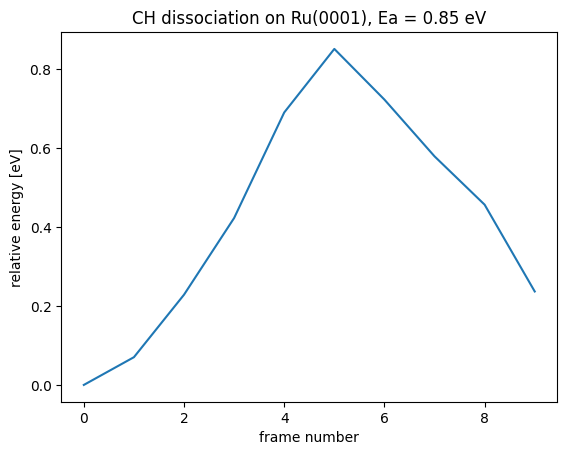

In [15]:
# Plot the reaction coordinate

es = [e - es[0] for e in es]
plt.plot(es)
plt.xlabel("frame number")
plt.ylabel("relative energy [eV]")
plt.title(f"CH dissociation on Ru(0001), Ea = {max(es):1.2f} eV")
plt.savefig("CH_dissoc_on_Ru_0001.png")

To generalize an interactive visualization, use `ase gui` from the command line or the X3D package

In [ ]:
# Make an interative html file of the optimized neb trajectory
x3d = X3D(optimized_neb)
x3d.write("optimized_neb_ch_disoc_on_Ru0001.html")